## Import necessary libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.metrics import r2_score, mean_squared_error
sb.set() # set the default Seaborn style for graphics

## Extract csv file


In [2]:
data = pd.read_csv('resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0


## To obtain `CombinedDataCleaned` (no outliers from both NumData and CatData)


In [3]:
NumData = pd.DataFrame(data[['floor_area_sqm', 'lease_commence_date']])

In [4]:
flat_type = pd.DataFrame(data[['flat_type']])
mapping = {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4, '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}
data['flat_type_num'] = flat_type['flat_type'].map(mapping)

storey_range = pd.DataFrame(data[['storey_range']])
mapping = {'01 TO 03': 2, '04 TO 06': 5, '07 TO 09': 8, '10 TO 12': 11, '13 TO 15': 14, '16 TO 18': 17, '19 TO 21': 20, '22 TO 24': 23, '25 TO 27': 26, '28 TO 30': 29, '31 TO 33': 32, '34 TO 36': 35, '37 TO 39': 38, '40 TO 42': 41}
data['Story_range_num'] = storey_range["storey_range"].map(mapping)

flat_model = pd.DataFrame(data[['flat_model']])
mapping = {'2-room': 1, 'Adjoined flat': 2, 'Apartment': 3, 'Improved': 4, 'Improved-Maisonette': 5, 'Maisonette': 6, 'Model A': 7, 'Model A-Maisonette': 8, 'Model A2': 9, 'Multi Generation': 10, 'New Generation': 11, 'Premium Apartment': 12, 'Premium Maisonette': 13, 'Simplified': 14, 'Standard': 15, 'Terrace': 16}
data['flat_model_num'] = flat_model['flat_model'].map(mapping)

CatData = pd.DataFrame(data[['flat_type_num', 'Story_range_num','flat_model_num']])

CombinedDataCleaned = pd.concat([NumData, CatData,data['resale_price']], axis=1)

CombinedDataCleaned.info()

# Calculate the quartiles
Q1 = CombinedDataCleaned.quantile(0.25)
Q3 = CombinedDataCleaned.quantile(0.75)

# Rule to identify outliers
rule = ((CombinedDataCleaned < (Q1 - 1.5 * (Q3 - Q1))) | (CombinedDataCleaned > (Q3 + 1.5 * (Q3 - Q1))))

outliers = rule.any(axis = 1)   # axis 0 is row, 1 is column

# Which row indices correspond to outliers in the dataframe?
outlierindices = outliers.index[outliers == True]



# Remove the outliers based on the row indices obtained above
CombinedDataCleaned.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
CombinedDataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369651 entries, 0 to 369650
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       369651 non-null  float64
 1   lease_commence_date  369651 non-null  int64  
 2   flat_type_num        369651 non-null  int64  
 3   Story_range_num      369651 non-null  int64  
 4   flat_model_num       369651 non-null  int64  
 5   resale_price         369651 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 16.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 360419 entries, 0 to 369648
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       360419 non-null  float64
 1   lease_commence_date  360419 non-null  int64  
 2   flat_type_num        360419 non-null  int64  
 3   Story_range_num      360419 non-null  int64  
 4   flat_model_num 

# We will compare the R^2 and MSE for all three models to determine the best model and also check the feature importance score to determine which predictors are the best 

## LASSO REGRESSION

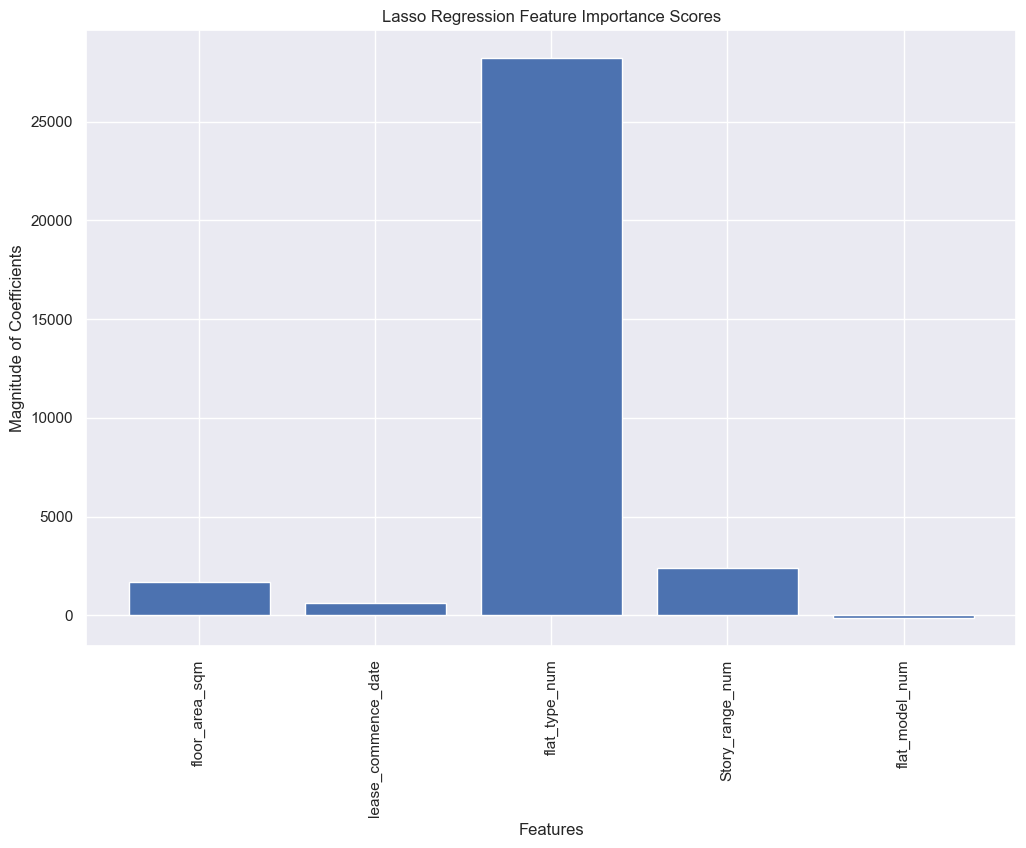

flat_type_num: 28195.77
Story_range_num: 2380.19
floor_area_sqm: 1706.35
lease_commence_date: 631.44
flat_model_num: -152.70


In [5]:
import pandas as pd
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import train_test_split

# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Lasso Regression model with cross-validation to find the best value of alpha
model = LassoCV(cv=5)
model.fit(X, y)

# Fit the Lasso Regression model
model = Lasso(alpha=model.alpha_)
model.fit(X_train, y_train)

# Predict using the Lasso Regression model on test data
y_pred = model.predict(X_test)

# Calculate R-squared and MSE on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Get the coefficients of the model
coef = model.coef_

# Plot the feature importance scores
plt.figure(figsize=(12,8))
plt.bar(range(len(coef)), coef)
plt.xticks(range(len(coef)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Magnitude of Coefficients')
plt.title('Lasso Regression Feature Importance Scores')
plt.show()

# Create a dictionary of feature importance scores
feature_scores = {feature: score for feature, score in zip(X.columns, coef)}

# Sort the dictionary by value in descending order
sorted_scores = sorted(feature_scores.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the feature importance scores in descending order
for feature, score in sorted_scores:
    print('{}: {:.2f}'.format(feature, score))

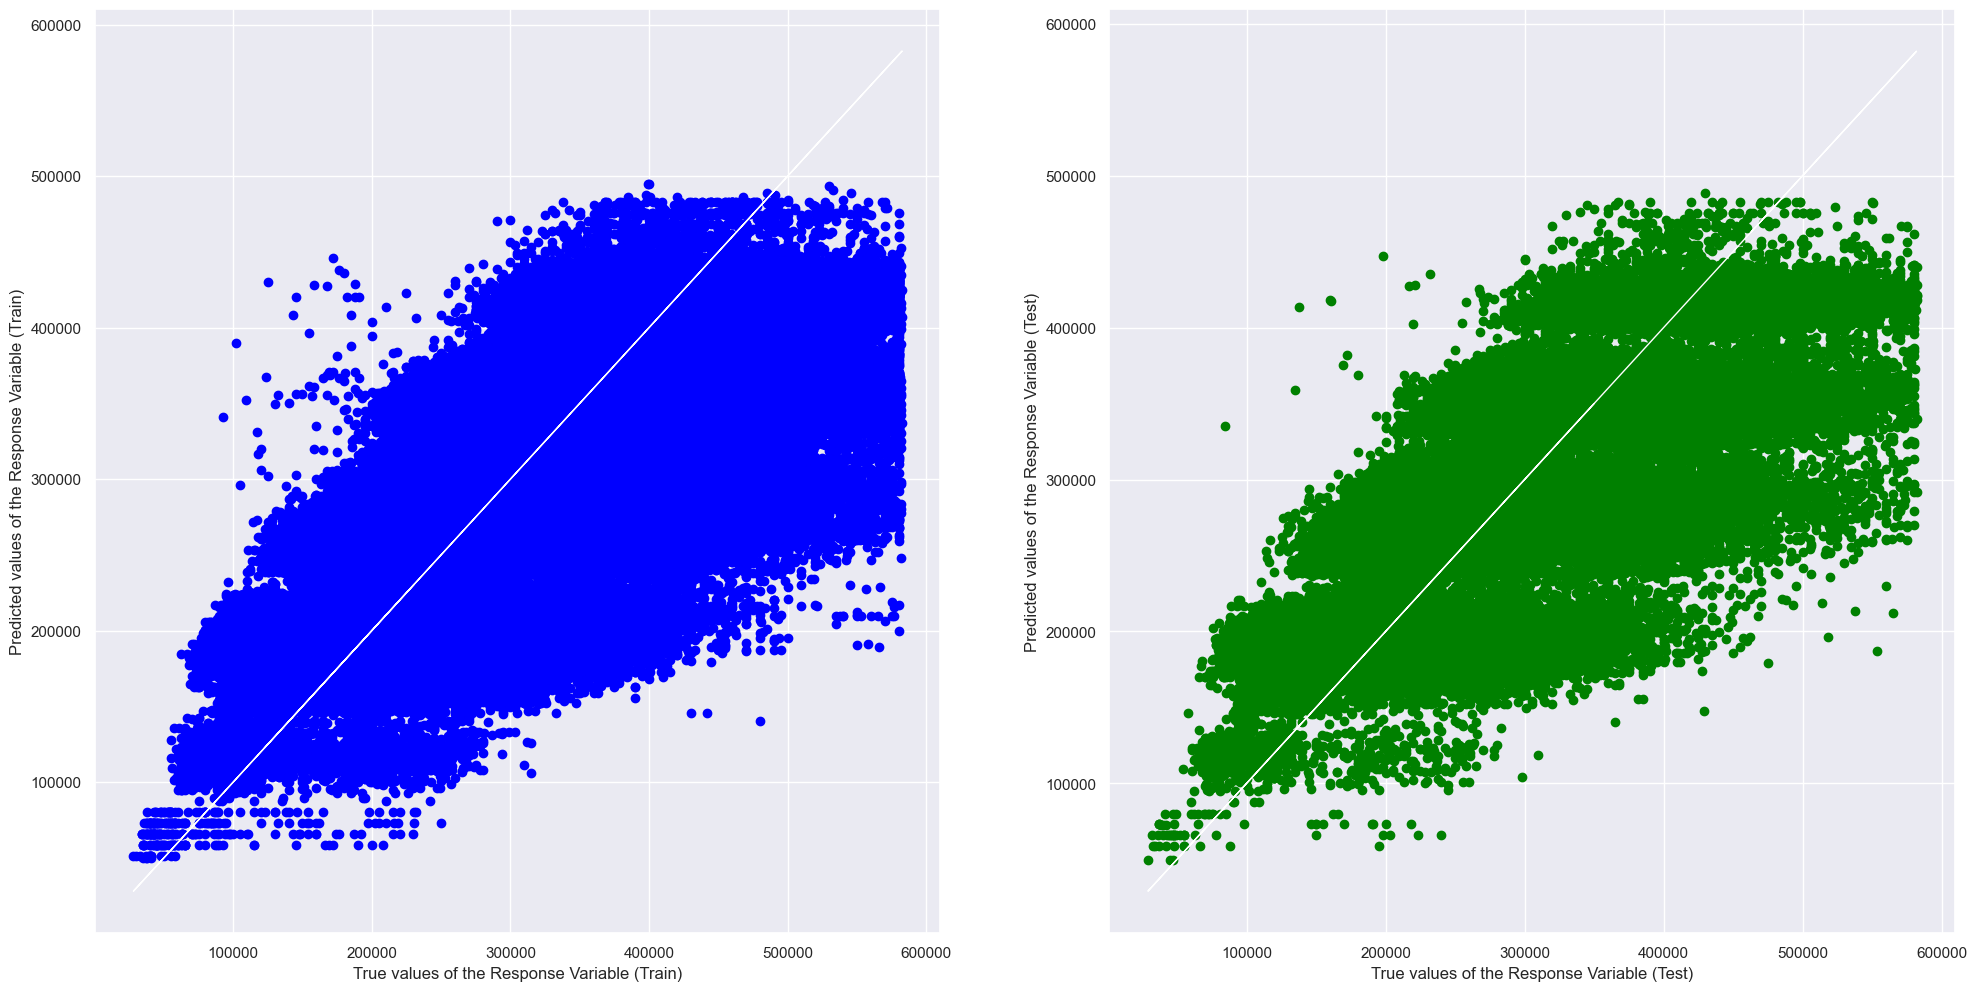

In [6]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [7]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", model.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, model.predict(X_train)))
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2)
print("Mean Squared Error (MSE) \t:", mse)
print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5259255425102897
Mean Squared Error (MSE) 	: 4963562519.526854

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5288131519038053
Mean Squared Error (MSE) 	: 4956720673.498274



## GRADIENT BOOSTING REGRESSION

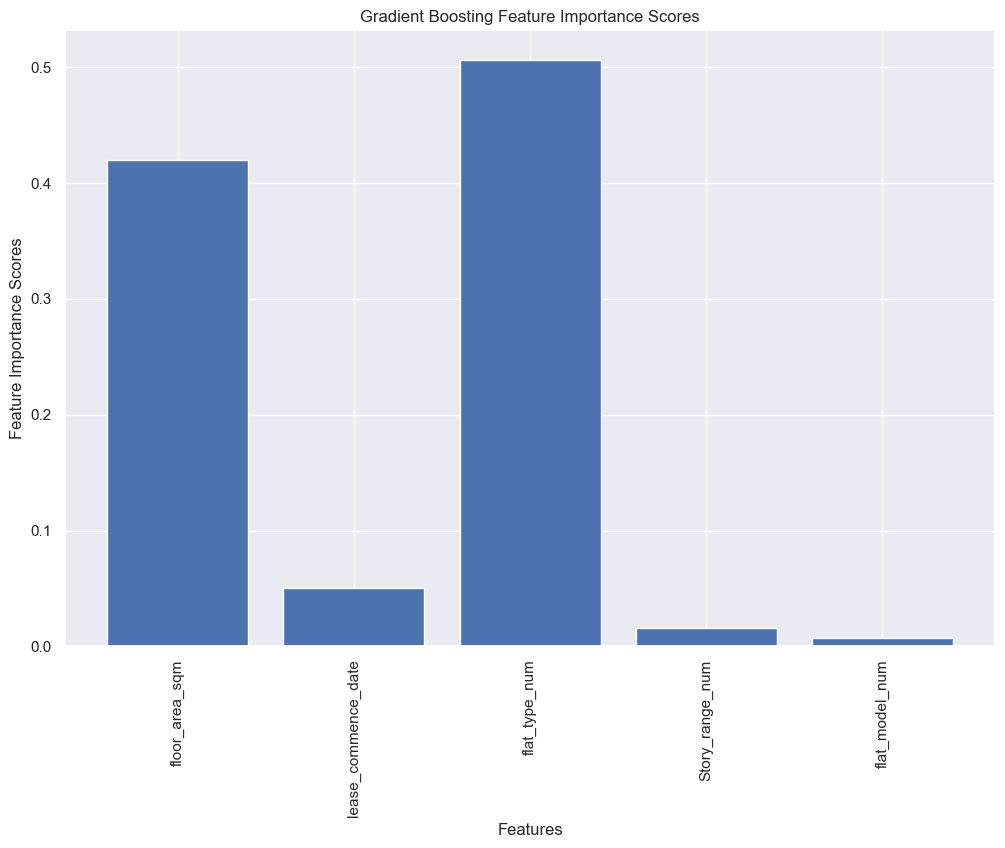

flat_type_num: 0.51
floor_area_sqm: 0.42
lease_commence_date: 0.05
Story_range_num: 0.02
flat_model_num: 0.01


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict using the Gradient boosting model on test data
y_pred = model.predict(X_test)

# Calculate R-squared and MSE on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Get the feature importance scores
feature_importances = model.feature_importances_

# Create a bar plot of the feature importance scores
plt.figure(figsize=(12,8))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Scores')
plt.title('Gradient Boosting Feature Importance Scores')
plt.show()

# Print the feature importance scores in descending order
sorted_scores = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, score in sorted_scores:
    print('{}: {:.2f}'.format(feature, score))

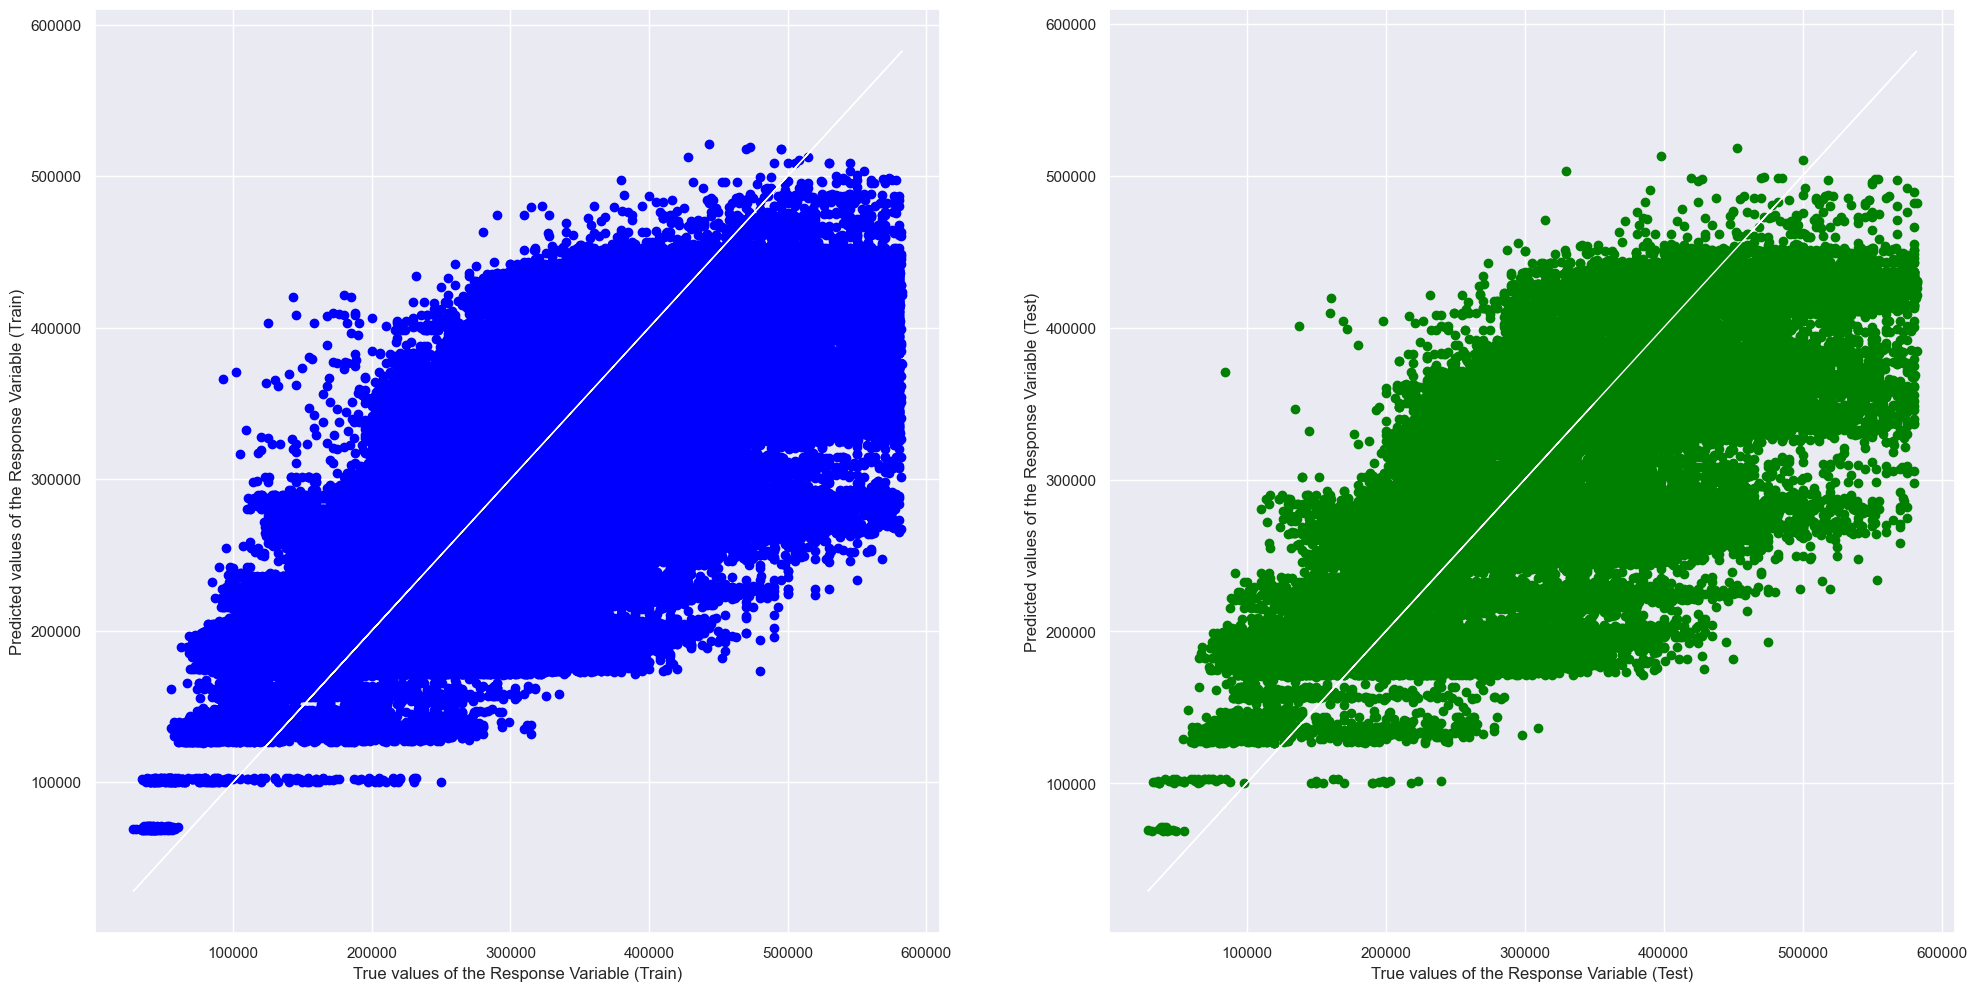

In [9]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [10]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", model.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, model.predict(X_train)))
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2)
print("Mean Squared Error (MSE) \t:", mse)
print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5733618889569008
Mean Squared Error (MSE) 	: 4466903677.090061

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5746426533008133
Mean Squared Error (MSE) 	: 4474610364.289704



## RANDOM FOREST

In [11]:
# Import Required Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the Dataset into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest Model and Train It
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict using the Random Forest model on test data
y_pred = rf.predict(X_test)

# Calculate R-squared and MSE on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the Feature Importances
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature '%s' (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature 'flat_type_num' (0.650123)
2. feature 'floor_area_sqm' (0.233180)
3. feature 'lease_commence_date' (0.075076)
4. feature 'Story_range_num' (0.027487)
5. feature 'flat_model_num' (0.014133)


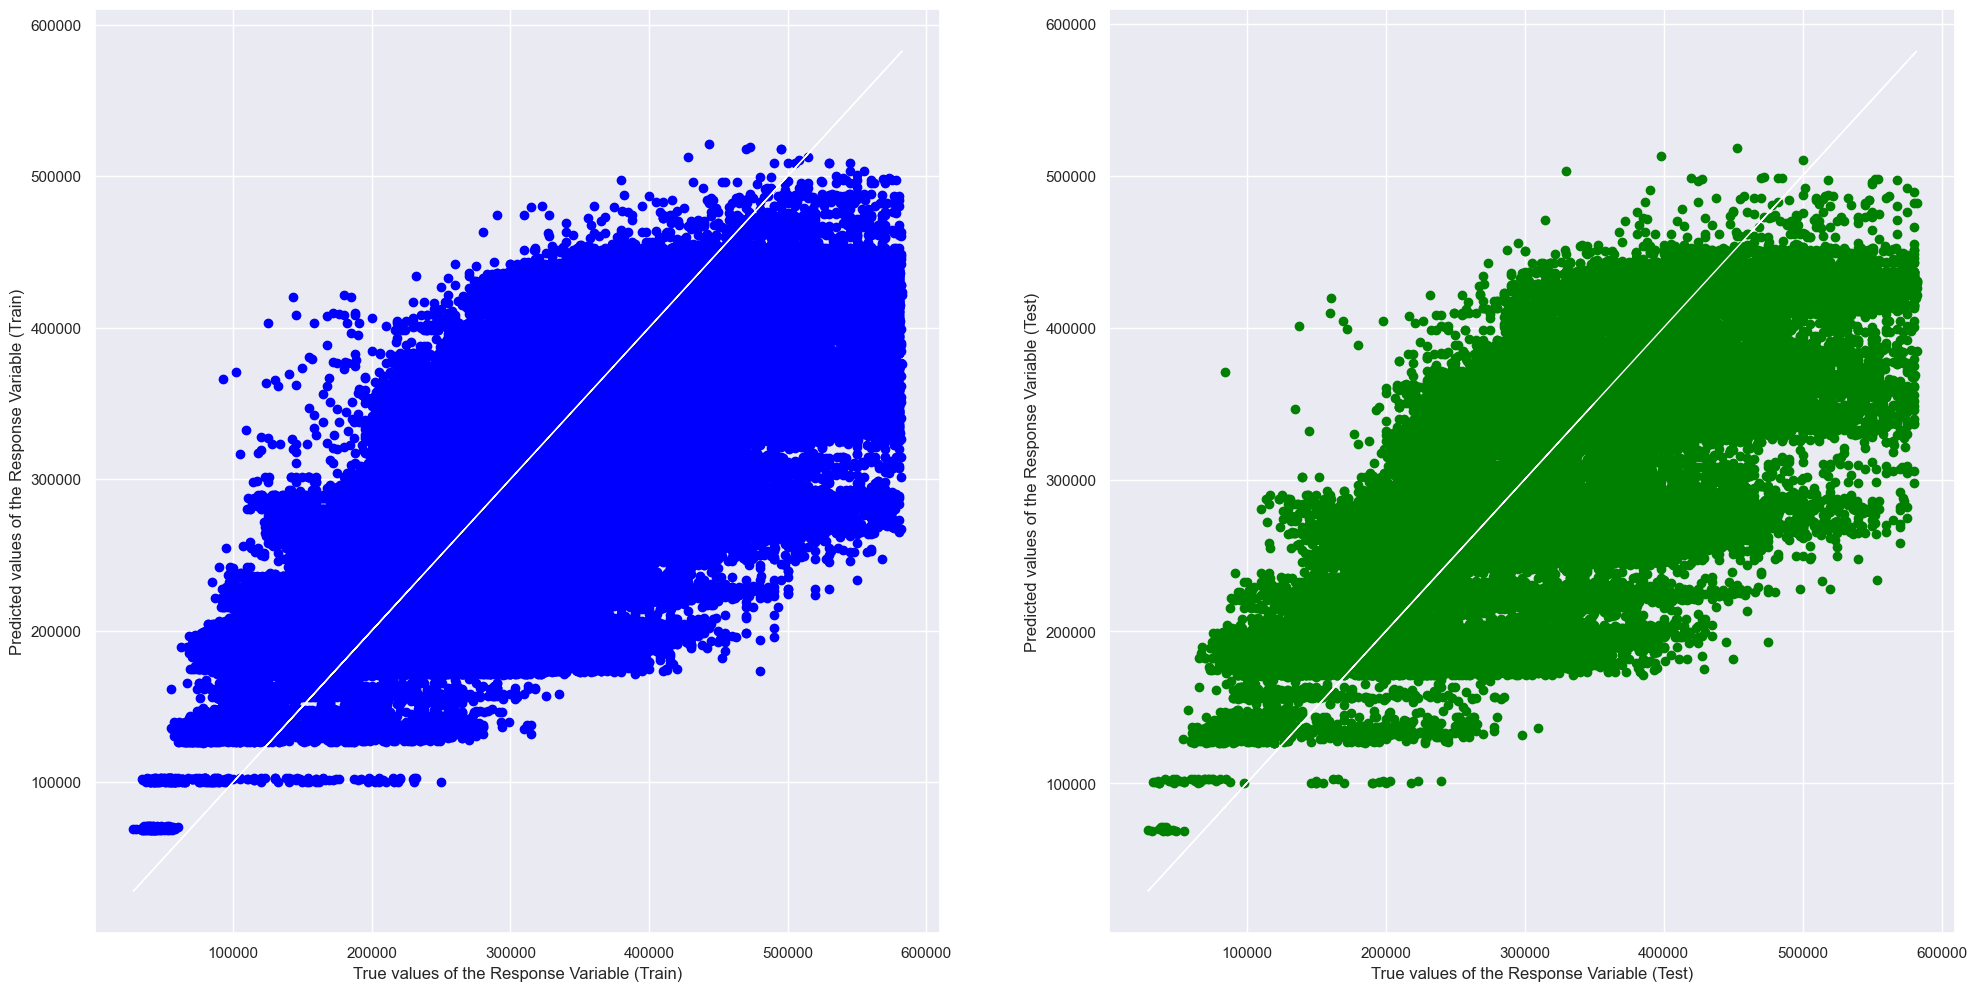

In [12]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [13]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", rf.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, rf.predict(X_train)))
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2)
print("Mean Squared Error (MSE) \t:", mse)
print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6189667361514284
Mean Squared Error (MSE) 	: 3989420643.217856

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5905393176400597
Mean Squared Error (MSE) 	: 4307383021.064031



## From the 3 different models used, Random forest, Lasso Regression and Gradient boosting

## Random Forest has the highest R^2 and lowest MSE which means it is the best performing model out of the 3.

## `flat_type_num` and `floor_area_sqm` seems have a very high feature importance in most of these models by consistently having a high feature importance score, implying it might be the best predictors in predicting the resale_price of a HDB flat out of all the predictors. 

## We further test the hypothesis with additional machine models later on.
